## 0. Download dataset

In [1]:
# way 1
!wget https://motchallenge.net/data/MOT17.zip

# way 2: might not be available
# !gdown 1vOj9OpxeyozWzpPCtUY7fDVaBQwsPM9n

--2024-02-28 08:33:00--  https://motchallenge.net/data/MOT17.zip
Resolving motchallenge.net (motchallenge.net)... 131.159.19.34, 2a09:80c0:18::1034
Connecting to motchallenge.net (motchallenge.net)|131.159.19.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5860214001 (5.5G) [application/zip]
Saving to: ‘MOT17.zip’

MOT17.zip           100%[===================>]   5.46G  14.3MB/s    in 6m 50s  

2024-02-28 08:39:51 (13.6 MB/s) - ‘MOT17.zip’ saved [5860214001/5860214001]



In [2]:
!unzip -qq MOT17.zip

## 1. Import libraries

In [3]:
!pip install ultralytics -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 716.2/716.2 kB 11.2 MB/s eta 0:00:00


In [4]:
import pandas as pd
import os
import yaml
import shutil
import configparser
import ultralytics
ultralytics.checks()

from tqdm import tqdm
from ultralytics import YOLO

Ultralytics YOLOv8.1.19 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 37.4/78.2 GB disk)


## 2. Convert to YOLO format

In [ ]:
def convert_to_yolo_format(bb, img_width, img_height):
    # format mot17 (x_min, y_min, bb_w, bb_h) convert to format yolo (x_center, y_center, bb_w, bb_h)
    x_center = bb['bb_left'] + (bb['bb_width'] / 2)
    y_center = bb['bb_top'] + (bb['bb_height'] / 2)

    # Normalize the coordinates by the dimensions of the image
    # Yolo format must normalize step
    x_center /= img_width
    y_center /= img_height
    bb_width_normalized = bb['bb_width'] / img_width
    bb_height_normalized = bb['bb_height'] / img_height

    # Clip the values to make sure they are between 0 and 1
    x_center = max(min(x_center, 1), 0)
    y_center = max(min(y_center, 1), 0)
    bb_width_normalized = max(min(bb_width_normalized, 1), 0)
    bb_height_normalized = max(min(bb_height_normalized, 1), 0)

    return (x_center, y_center, bb_width_normalized, bb_height_normalized)

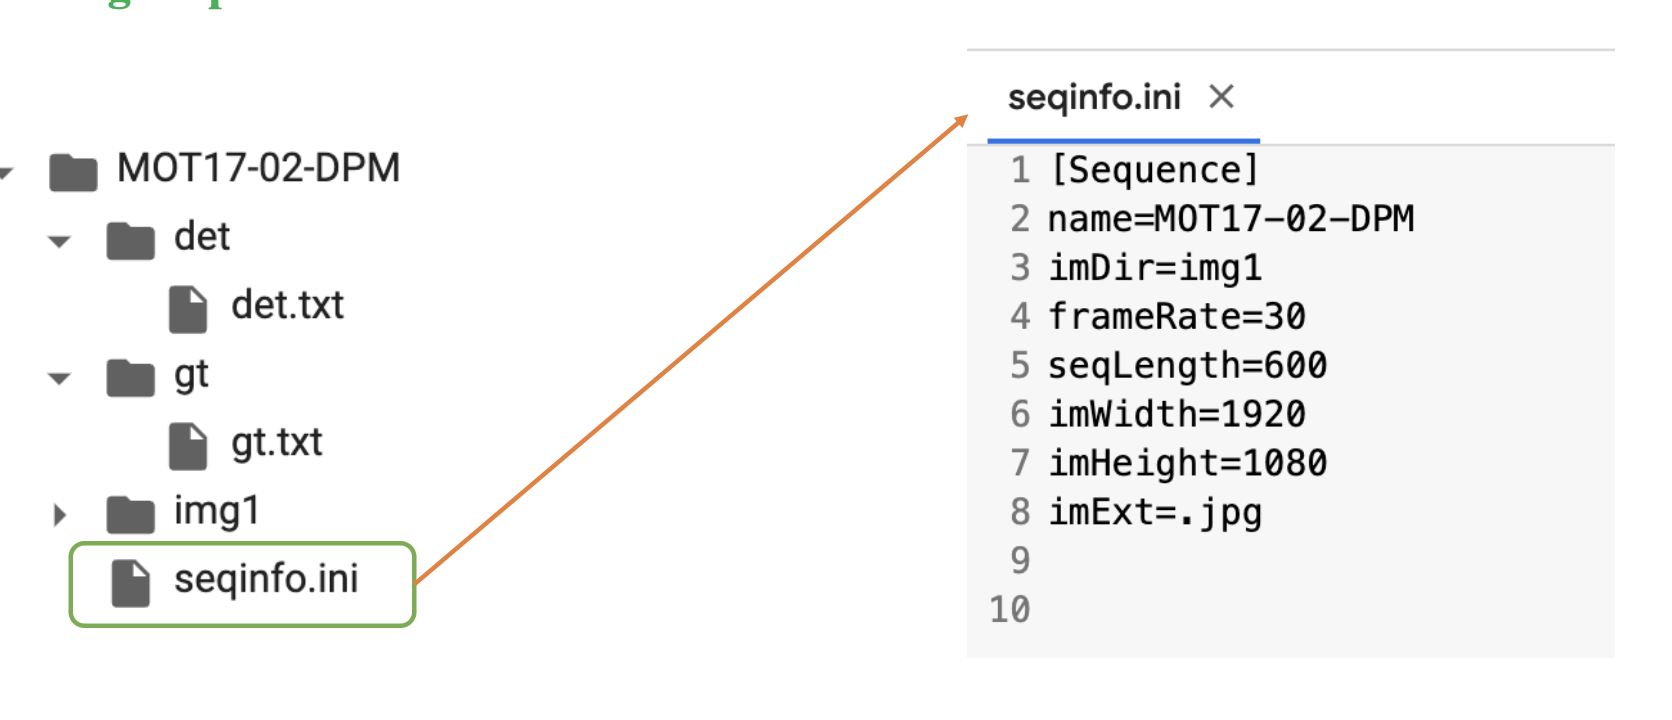

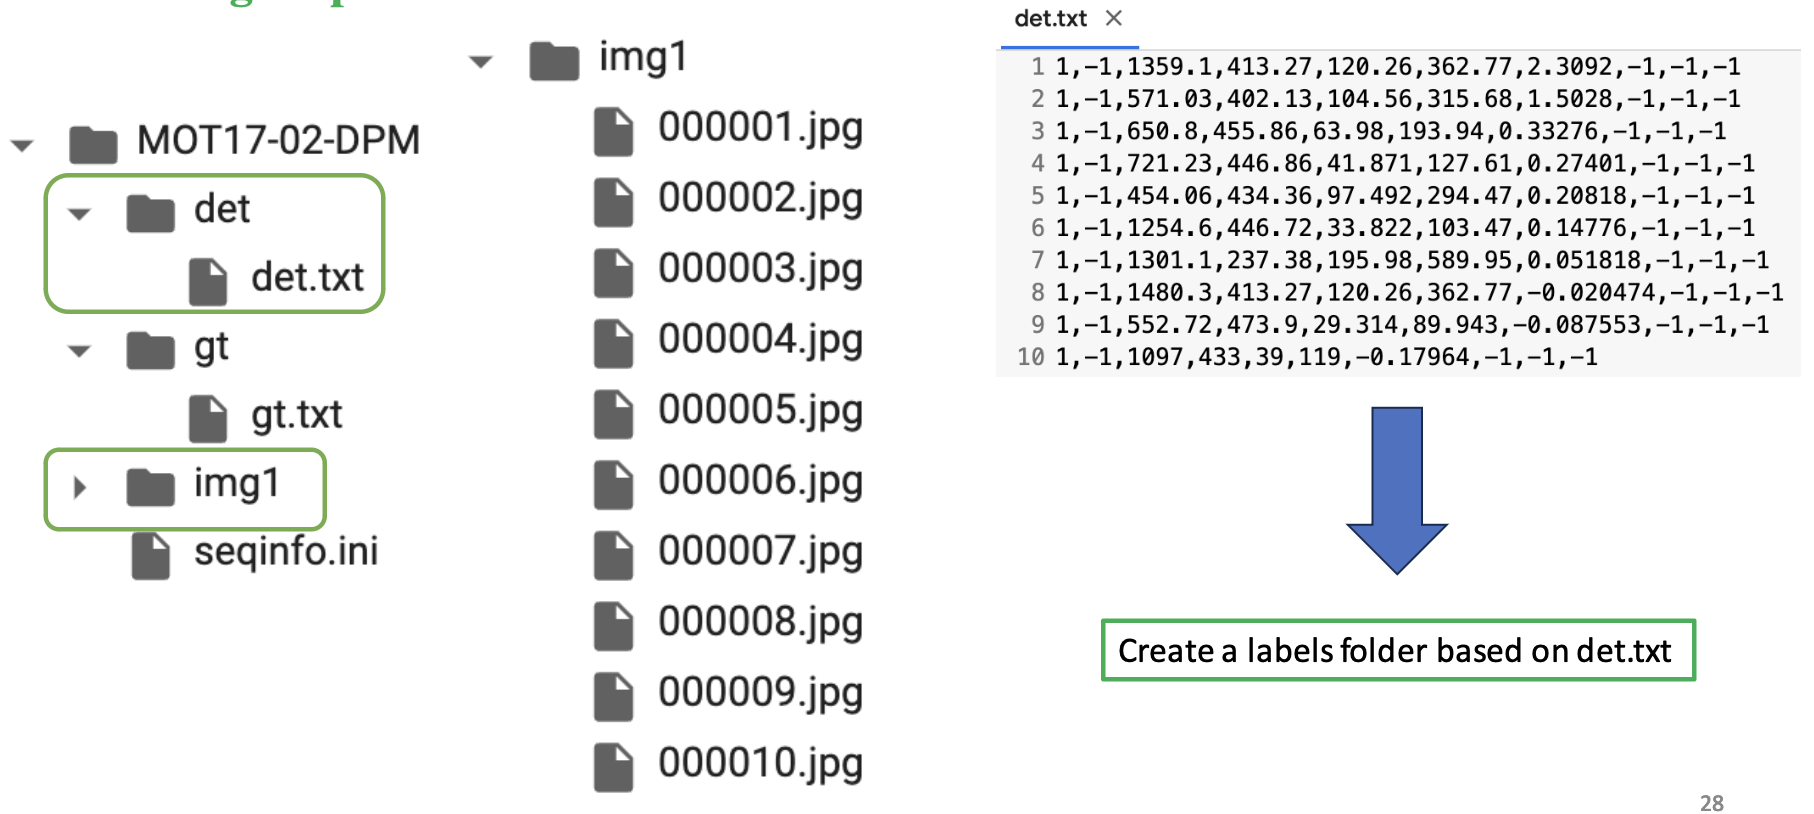

In [16]:
def process_folder(folder_path):
    # Read image dimensions from seqinfo.ini
    config = configparser.ConfigParser()
    config.read(os.path.join(folder_path, 'seqinfo.ini'))
    img_width = int(config['Sequence']['imWidth'])
    img_height = int(config['Sequence']['imHeight'])

    # Load ground truth data
    gt_path = os.path.join(folder_path, 'det/det.txt')
    gt_data = pd.read_csv(
        gt_path,
        header=None,
        names=['frame', 'id', 'bb_left', 'bb_top', 'bb_width', 'bb_height', 'conf', 'class', 'visibility']
    )

    labels_folder = os.path.join(folder_path, 'labels')
    os.makedirs(labels_folder, exist_ok=True)

    for frame_number in gt_data['frame'].unique():
        frame_data = gt_data[gt_data['frame'] == frame_number]
        label_file = os.path.join(labels_folder, f'{frame_number:06d}.txt')

        with open(label_file, 'w') as file:
            for _, row in frame_data.iterrows():
                yolo_bb = convert_to_yolo_format(row, img_width, img_height)
                file.write(f'0 {yolo_bb[0]} {yolo_bb[1]} {yolo_bb[2]} {yolo_bb[3]}\n')

In [20]:
def process_all_folders(base_directory):
    # List all subdirectories in the base directory
    for folder_name in tqdm(os.listdir(base_directory)):
        folder_path = os.path.join(base_directory, folder_name)

        # Delete folder not contain 'FRCNN' in name
        if 'FRCNN' not in folder_name:
            os.system(f'rm -rf {folder_path}')
            continue

        if os.path.isdir(folder_path):
            process_folder(folder_path)

In [21]:
process_all_folders('MOT17/train')
process_all_folders('MOT17/test')

100%|██████████| 17/17 [00:11<00:00,  1.52it/s]


## 3. Move file

In [22]:
def rename_and_move_files(src_folder, dst_folder, folder_name, file_extension):
    for filename in os.listdir(src_folder):
        if filename.endswith(file_extension):
            # Include folder name in the new filename
            new_filename = f'{folder_name}_{filename}'
            shutil.move(os.path.join(src_folder, filename), os.path.join(dst_folder, new_filename))

In [23]:
def move_files_all_folders(base_directory):
    images_dir = os.path.join(base_directory, 'images')
    labels_dir = os.path.join(base_directory, 'labels')
    os.makedirs(images_dir, exist_ok=True)
    os.makedirs(labels_dir, exist_ok=True)

    for folder_name in tqdm(os.listdir(base_directory)):
        if folder_name in ['images', 'labels']:  # Skip these folders
            continue

        folder_path = os.path.join(base_directory, folder_name)
        if os.path.isdir(folder_path):
            rename_and_move_files(os.path.join(folder_path, 'img1'), images_dir, folder_name, '.jpg')
            rename_and_move_files(os.path.join(folder_path, 'labels'), labels_dir, folder_name, '.txt')

In [24]:
move_files_all_folders('MOT17/train')
move_files_all_folders('MOT17/test')

100%|██████████| 9/9 [00:00<00:00, 23.98it/s]


In [25]:
def delete_subfolders(base_directory):
    for folder_name in os.listdir(base_directory):
        folder_path = os.path.join(base_directory, folder_name)
        if os.path.isdir(folder_path) and folder_name not in ['images', 'labels']:
            shutil.rmtree(folder_path)
            print(f"Deleted folder: {folder_name}")

In [26]:
# Delete all subfolders except 'images' and 'labels'
delete_subfolders('MOT17/train')
delete_subfolders('MOT17/test')

Deleted folder: MOT17-09-FRCNN
Deleted folder: MOT17-02-FRCNN
Deleted folder: MOT17-10-FRCNN
Deleted folder: MOT17-13-FRCNN
Deleted folder: MOT17-05-FRCNN
Deleted folder: MOT17-04-FRCNN
Deleted folder: MOT17-11-FRCNN
Deleted folder: MOT17-03-FRCNN
Deleted folder: MOT17-01-FRCNN
Deleted folder: MOT17-12-FRCNN
Deleted folder: MOT17-06-FRCNN
Deleted folder: MOT17-08-FRCNN
Deleted folder: MOT17-14-FRCNN
Deleted folder: MOT17-07-FRCNN


## 4. Create yaml file

In [27]:
class_labels = [
    'objects'
]
dataset_root_dir = os.path.join(
    os.getcwd(),
    'MOT17'
)
yolo_yaml_path = os.path.join(
    dataset_root_dir,
    'mot17_data.yml'
)

data_yaml = {
    'path': dataset_root_dir,
    'train': 'train/images',
    'val': 'test/images',
    'nc': len(class_labels),
    'names': class_labels
}

with open(yolo_yaml_path, 'w') as f:
    yaml.dump(data_yaml, f, default_flow_style=False)

## 5. Training

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from ultralytics import YOLO

# Load the YOLOv8 model
model = YOLO('yolov8s.pt')

# Config
epochs = 30
batch_size = -1 # Auto scale based on GPU memory
img_size = 640
project_name = 'models/yolo'
name = 'yolov8s_mot17_det'

# Train the model
results = model.train(
    data=yolo_yaml_path,
    epochs=epochs,
    batch=batch_size,
    imgsz=img_size,
    project=project_name,
    name=name
)

New https://pypi.org/project/ultralytics/8.1.0 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.222 🚀 Python-3.11.5 torch-2.1.1 CUDA:0 (NVIDIA GeForce RTX 3060, 12036MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/home/aivn12s1/thangdd/project_object_tracking/MOT17/mot17_data.yml, epochs=30, patience=50, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=models/yolo, name=yolov8s_mot17_det3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6.23M/6.23M [00:00<00:00, 10.2MB/s]


AMP: checks passed ✅
AutoBatch: Computing optimal batch size for imgsz=640
AutoBatch: CUDA:0 (NVIDIA GeForce RTX 3060) 11.75G total, 0.25G reserved, 0.11G allocated, 11.39G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
    11135987       28.65         0.480         8.772         65.88        (1, 3, 640, 640)                    list
    11135987       57.29         0.732         9.154         24.55        (2, 3, 640, 640)                    list
    11135987       114.6         1.109         16.44         28.98        (4, 3, 640, 640)                    list
    11135987       229.2         1.896         30.17         38.57        (8, 3, 640, 640)                    list
    11135987       458.4         3.571          59.6         65.37       (16, 3, 640, 640)                    list
AutoBatch: Using batch-size 32 for CUDA:0 7.19G/11.75G (61%) ✅


train: Scanning /home/aivn12s1/thangdd/project_object_tracking/MOT17/train/labels... 5316 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5316/5316 [00:05<00:00, 1011.68it/s]


train: New cache created: /home/aivn12s1/thangdd/project_object_tracking/MOT17/train/labels.cache


val: Scanning /home/aivn12s1/thangdd/project_object_tracking/MOT17/test/labels... 5908 images, 11 backgrounds, 0 corrupt: 100%|██████████| 5919/5919 [00:03<00:00, 1526.12it/s]


val: New cache created: /home/aivn12s1/thangdd/project_object_tracking/MOT17/test/labels.cache
Plotting labels to models/yolo/yolov8s_mot17_det3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to models/yolo/yolov8s_mot17_det3
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      8.12G      1.095     0.7265     0.9617        104        640: 100%|██████████| 167/167 [00:59<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 93/93 [00:21<00:00,  4.24it/s]


                   all       5919     110141       0.85      0.782      0.882      0.553

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      8.14G      0.998     0.5988     0.9331         56        640: 100%|██████████| 167/167 [00:58<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 93/93 [00:21<00:00,  4.36it/s]


                   all       5919     110141      0.893      0.815      0.907      0.607

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      7.81G     0.9428     0.5573      0.917         85        640: 100%|██████████| 167/167 [00:58<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 93/93 [00:21<00:00,  4.37it/s]


                   all       5919     110141      0.869      0.815      0.894      0.571

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      7.89G       0.93     0.5494     0.9146         71        640: 100%|██████████| 167/167 [00:58<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 93/93 [00:21<00:00,  4.36it/s]


                   all       5919     110141      0.879      0.798      0.882      0.577

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      7.91G     0.8723      0.514     0.9004         87        640: 100%|██████████| 167/167 [00:58<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 93/93 [00:21<00:00,  4.37it/s]


                   all       5919     110141      0.874      0.805      0.895      0.598

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      8.22G     0.8481     0.4912     0.8937        108        640: 100%|██████████| 167/167 [00:58<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 93/93 [00:21<00:00,  4.39it/s]


                   all       5919     110141      0.873      0.831      0.904      0.611

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      8.14G     0.8213     0.4735     0.8859         90        640: 100%|██████████| 167/167 [00:58<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 93/93 [00:21<00:00,  4.39it/s]


                   all       5919     110141       0.88      0.817      0.904      0.603

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      8.19G     0.7898     0.4584     0.8806         91        640: 100%|██████████| 167/167 [00:58<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 93/93 [00:21<00:00,  4.38it/s]


                   all       5919     110141      0.881      0.808      0.884      0.579

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      8.14G     0.7743     0.4481     0.8764         84        640: 100%|██████████| 167/167 [00:58<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 93/93 [00:21<00:00,  4.40it/s]


                   all       5919     110141      0.897      0.815      0.908      0.616

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      8.04G      0.749     0.4319     0.8701        150        640: 100%|██████████| 167/167 [00:58<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 93/93 [00:21<00:00,  4.41it/s]


                   all       5919     110141      0.898      0.792      0.892      0.628

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      8.03G     0.7393     0.4219     0.8682         36        640: 100%|██████████| 167/167 [00:58<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 93/93 [00:21<00:00,  4.40it/s]


                   all       5919     110141       0.89      0.817      0.905      0.619

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30       8.1G     0.7201     0.4101      0.864         80        640: 100%|██████████| 167/167 [00:58<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 93/93 [00:21<00:00,  4.40it/s]


                   all       5919     110141      0.896      0.804      0.901      0.613

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      8.26G      0.707     0.4042     0.8622         63        640: 100%|██████████| 167/167 [00:58<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 93/93 [00:21<00:00,  4.40it/s]


                   all       5919     110141      0.895      0.801        0.9      0.623

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      8.06G      0.704     0.4014     0.8617         75        640: 100%|██████████| 167/167 [00:58<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 93/93 [00:21<00:00,  4.36it/s]


                   all       5919     110141      0.899      0.812      0.907      0.625

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      7.85G     0.6923     0.3947     0.8603        107        640: 100%|██████████| 167/167 [00:58<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 93/93 [00:21<00:00,  4.37it/s]


                   all       5919     110141      0.887      0.814      0.901      0.624

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      8.21G     0.6809      0.389     0.8573         72        640: 100%|██████████| 167/167 [00:58<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 93/93 [00:21<00:00,  4.36it/s]


                   all       5919     110141      0.894       0.81      0.904      0.635

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      8.22G     0.6577     0.3758     0.8534        139        640: 100%|██████████| 167/167 [00:58<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 93/93 [00:21<00:00,  4.36it/s]


                   all       5919     110141      0.896      0.811      0.908      0.633

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      7.88G     0.6489     0.3696     0.8508         92        640: 100%|██████████| 167/167 [00:58<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 93/93 [00:21<00:00,  4.36it/s]


                   all       5919     110141      0.901      0.793      0.893      0.619

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      7.94G      0.642     0.3644     0.8491         70        640: 100%|██████████| 167/167 [00:58<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 93/93 [00:21<00:00,  4.31it/s]


                   all       5919     110141      0.904      0.803      0.902       0.64

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      8.21G     0.6277     0.3581     0.8458         90        640: 100%|██████████| 167/167 [00:58<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 93/93 [00:21<00:00,  4.42it/s]


                   all       5919     110141      0.896      0.811      0.905      0.647
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30       7.6G     0.6209     0.3517     0.8346         74        640: 100%|██████████| 167/167 [00:57<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 93/93 [00:21<00:00,  4.40it/s]


                   all       5919     110141      0.892      0.817      0.901      0.637

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      7.58G     0.6087     0.3462     0.8351         32        640: 100%|██████████| 167/167 [00:57<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 93/93 [00:21<00:00,  4.41it/s]


                   all       5919     110141      0.905      0.804      0.904      0.642

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      7.59G     0.5929     0.3363       0.83         36        640: 100%|██████████| 167/167 [00:57<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 93/93 [00:21<00:00,  4.41it/s]


                   all       5919     110141      0.898      0.807      0.905      0.646

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      7.52G     0.5852     0.3307      0.827         53        640: 100%|██████████| 167/167 [00:57<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 93/93 [00:21<00:00,  4.42it/s]


                   all       5919     110141      0.903      0.801      0.901      0.644

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      7.61G     0.5676     0.3203     0.8253         52        640: 100%|██████████| 167/167 [00:57<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 93/93 [00:21<00:00,  4.41it/s]


                   all       5919     110141      0.904      0.814      0.907      0.651

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      7.66G      0.556     0.3137     0.8219         58        640: 100%|██████████| 167/167 [00:57<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 93/93 [00:21<00:00,  4.42it/s]


                   all       5919     110141      0.903      0.808      0.908      0.654

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      7.55G     0.5452     0.3082     0.8196         48        640: 100%|██████████| 167/167 [00:57<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 93/93 [00:21<00:00,  4.41it/s]


                   all       5919     110141      0.903      0.806      0.908      0.651

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      7.53G     0.5304     0.2982     0.8177         61        640: 100%|██████████| 167/167 [00:57<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 93/93 [00:21<00:00,  4.42it/s]


                   all       5919     110141      0.906      0.803      0.905      0.653

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      7.56G     0.5258     0.2958     0.8165         35        640: 100%|██████████| 167/167 [00:57<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 93/93 [00:21<00:00,  4.42it/s]


                   all       5919     110141      0.907      0.796      0.901      0.647

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      7.57G     0.5106      0.287     0.8138         55        640: 100%|██████████| 167/167 [00:57<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 93/93 [00:21<00:00,  4.41it/s]


                   all       5919     110141      0.903      0.805      0.903      0.653

30 epochs completed in 0.668 hours.
Optimizer stripped from models/yolo/yolov8s_mot17_det3/weights/last.pt, 22.5MB
Optimizer stripped from models/yolo/yolov8s_mot17_det3/weights/best.pt, 22.5MB

Validating models/yolo/yolov8s_mot17_det3/weights/best.pt...
Ultralytics YOLOv8.0.222 🚀 Python-3.11.5 torch-2.1.1 CUDA:0 (NVIDIA GeForce RTX 3060, 12036MiB)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 93/93 [00:24<00:00,  3.77it/s]


                   all       5919     110141      0.903      0.809      0.908      0.654
Speed: 0.1ms preprocess, 1.9ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to models/yolo/yolov8s_mot17_det3


## 6. Evaluation

In [ ]:
from ultralytics import YOLO

# Load the trained model
model_path = os.path.join(
    project_name, name, 'weights/best.pt'
)
model = YOLO(model_path)

metrics = model.val(
    project=project_name,
    name='detect/val'
)

Ultralytics YOLOv8.0.222 🚀 Python-3.11.5 torch-2.1.1 CUDA:0 (NVIDIA GeForce RTX 3060, 12036MiB)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning /home/aivn12s1/thangdd/project_object_tracking/MOT17/test/labels.cache... 5908 images, 11 backgrounds, 0 corrupt: 100%|██████████| 5919/5919 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 370/370 [00:33<00:00, 10.95it/s]


                   all       5919     110141      0.903      0.809      0.908      0.655
Speed: 0.1ms preprocess, 3.4ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to models/yolo/detect/val


## 7. Inference

In [ ]:
sample_path = 'MOT17/test/images/MOT17-01-FRCNN_000001.jpg'
results = model.predict(
    sample_path,
    project=project_name,
    name='detect/predict',
    save=True
)


image 1/1 /home/aivn12s1/thangdd/project_object_tracking/MOT17/test/images/MOT17-01-FRCNN_000001.jpg: 384x640 9 objectss, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)
Results saved to models/yolo/detect/predict2
